Imports

In [26]:
%run Data_Analysis_Functions.ipynb

#### Read all files and check the dfs

In [3]:
folder = "\Archive_23"
#folder = ""

In [4]:
households = pd.read_csv(f"..\Datalogs{folder}\Households.csv").sort_index(axis=1)
cons_firms = pd.read_csv(f"..\Datalogs{folder}\Consumer_Firms.csv").sort_index(axis=1)
cap_firms = pd.read_csv(f"..\Datalogs{folder}\Capital_Firms.csv").sort_index(axis=1)
pboard = pd.read_csv(f"..\Datalogs{folder}\Public_Info_Board.csv").sort_index(axis=1)
bank = pd.read_csv(f"..\Datalogs{folder}\Bank.csv").sort_index(axis=1)

Calculate number of agents to do a sense check

In [5]:
mask = households['date'].apply(lambda x: np.isnan(x) if isinstance(x, float) else False)

# filter dataframe using mask
filtered_df = households[mask]

timestep = int(households['date'].max())
#timestep = 15
n_households = households[households.date == 0].shape[0]
n_cons_firms = cons_firms[cons_firms.date == 0].shape[0]
n_cap_firms = cap_firms[cap_firms.date == 0].shape[0]
t = np.linspace(0,timestep, timestep +1)

In [6]:
print(f"Program has {n_households} households, {n_cons_firms} consumer firms, {n_cap_firms} capital firms, and runs for {timestep} timesteps")

Program has 250000 households, 10000 consumer firms, 2000 capital firms, and runs for 60 timesteps


Get sums and averages for each timestep

In [7]:
households_sum = households.groupby('date').sum().reset_index()
households_avg = households.groupby('date').mean().reset_index()
cons_firms_sum = cons_firms.groupby('date').sum().reset_index()
cons_firms_avg = cons_firms.groupby('date').mean().reset_index()
cap_firms_sum = cap_firms.groupby('date').sum().reset_index()
cap_firms_avg = cap_firms.groupby('date').mean().reset_index()

# Separate households into workers or firm owners
# Get id of households who are firm owners
firm_owner_ids = households[(households['date'] == 0) & (households['firm_owner'] == 1)]['id'].tolist()
households_workers = households[~households['id'].isin(firm_owner_ids)]
households_owners = households[households['id'].isin(firm_owner_ids)]

households_workers_avg = households_workers.groupby('date').mean().reset_index()
households_workers_sum = households_workers.groupby('date').sum().reset_index()
households_owners_avg = households_owners.groupby('date').mean().reset_index()
households_owners_sum = households_owners.groupby('date').sum().reset_index()

# Calculate the average of incomes for the firm owners appropriately
n_firm_owners = n_cap_firms + n_cons_firms
firm_owner_sum = households_owners.groupby('date')['firm_owner'].sum()
households_owners_avg.loc[:, 'income_dividend_average'] = households_owners.groupby('date')['income_dividend'].sum() / firm_owner_sum.values
households_owners_avg.loc[:, 'income_wage_average'] = households_owners.groupby('date')['income_wage'].sum() / (n_firm_owners - firm_owner_sum.values)

Delete the original dataframes to free memory

In [8]:
del households
del cons_firms
del cap_firms

Calculate aggregate data from sector columns

 "actual_spending_on_sector", "inventory_by_sector_", "offsets_sold_by_sector_", "planned_production_on_sector",
                "planned_spending_on_sector", "quantity_sold_by_sector", "total_cons_emissions_by_sector_","actual_production_on_sector",

In [9]:
# select columns in public board starting with "actual_spending_on_sector"
actual_spending = pboard.filter(regex='actual_spending_on_sector')
# sum up all the values in these columns and assign this to the column "total_actual_spending"
pboard['total_actual_spending'] = actual_spending.sum(axis=1)

# planned_spending_on_sector
planned_spending = pboard.filter(regex='planned_spending_on_sector')
pboard['total_planned_spending'] = planned_spending.sum(axis=1)

# do the same above for inventory_by_sector
inventory = pboard.filter(regex='inventory_by_sector')
pboard['total_inventory'] = inventory.sum(axis=1)

# planned_production_on_sector
planned_production = pboard.filter(regex='planned_production_on_sector')
pboard['total_planned_production'] = planned_production.sum(axis=1)
# actual_production_on_sector
actual_production = pboard.filter(regex='actual_production_on_sector')
pboard['total_actual_production'] = actual_production.sum(axis=1)

# quantity_sold_by_sector
quantity_sold = pboard.filter(regex='quantity_sold_by_sector')
pboard['total_quantity_sold'] = quantity_sold.sum(axis=1)

# total_cons_emissions_by_sector
total_cons_emissions = pboard.filter(regex='total_cons_emissions_by_sector')
pboard['total_cons_emissions'] = total_cons_emissions.sum(axis=1)
# offsets_sold_by_sector
offsets_sold = pboard.filter(regex='offsets_sold_by_sector')
pboard['total_offsets_sold'] = offsets_sold.sum(axis=1)


Calculate useful data for public board

In [22]:
pboard['spending_shortfall'] = pboard['total_planned_spending'] - pboard['total_actual_spending']
pboard['production_shortfall'] = pboard['total_planned_production'] - pboard['total_actual_production']
pboard['total_spending_growth'] = pboard['total_actual_spending'].pct_change() * 100

# Real spending adjusted for inflation ( consumer price level)
# Real consumer spending growth rate
# Real capital spending adjusted for capital good inflation
# Real capital spending growth rate

# GDP nominal :  consumer spending + capital spending + tax_revenue(assumed to be equal to government spending)

# GDP real : GDP nominal / consumer price level

## Plot the data

#### See which columns are present

In [12]:
print(households_avg.columns)
print(cons_firms_avg.columns)
print(cap_firms_avg.columns)
print(pboard.columns)
print(bank.columns)

Index(['date', 'c_excess_money', 'c_f', 'consumption_budget',
       'consumption_propensity', 'emission_sensitivity_avg', 'firm_owner',
       'id', 'income_average', 'income_current', 'income_dividend',
       'income_unemployment_benefit', 'income_wage', 'reservation_wage',
       'saving_propensity', 'saving_propensity_optimist',
       'saving_propensity_pessimist', 'savings', 'savings_desired',
       'sentiment', 'total_emissions', 'unemp_duration',
       'unemp_duration_upper_bound', 'unemployed'],
      dtype='object')
Index(['date', 'Leverage_ratio', 'Total_assets', 'active_job_postings',
       'average_profit', 'average_sale_quantity', 'bankrupt', 'capital_costs',
       'cash_on_hand', 'debt_interest_payments', 'debt_principal_payments',
       'desired_empl_count', 'desired_inventory', 'desired_machines',
       'dividend_payments', 'dividend_ratio', 'dividend_ratio_optimistic',
       'dividend_ratio_pessimistic', 'expected_wage_bill',
       'good_price_current', 'id',

### Plot Households

Original worker households

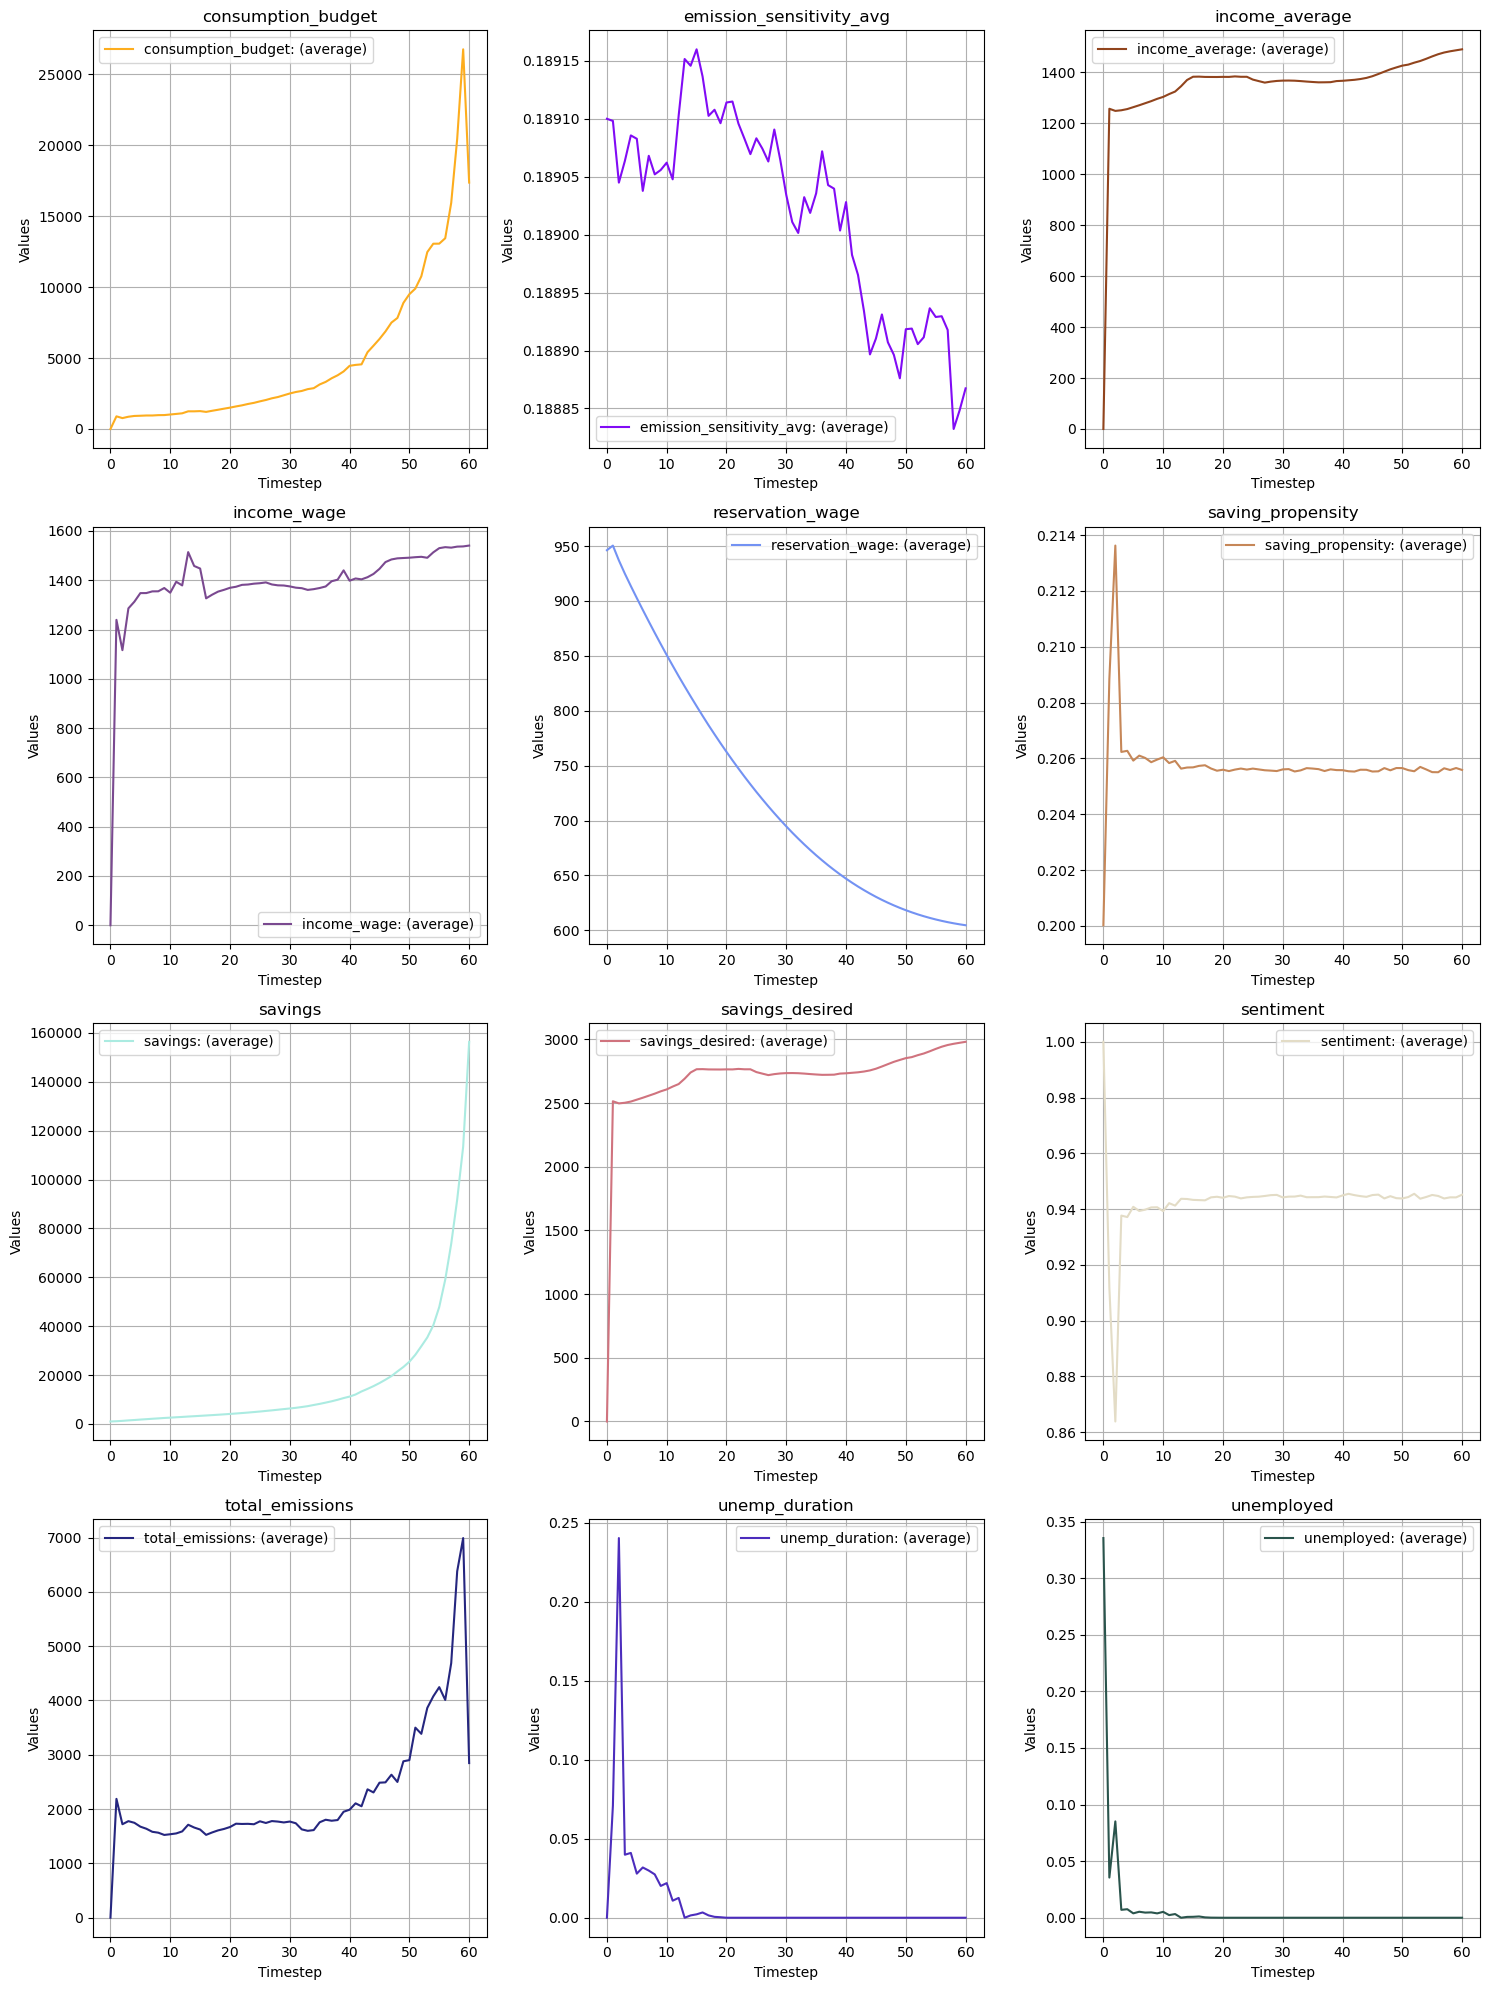

In [13]:
#cols_to_exclude = ['date']
#plot_values(households_sum,t,False, cols_to_exclude)
cols_to_exclude = ['date', 
                   "c_f", "c_excess_money", "consumption_propensity", 
                   "saving_propensity_optimist", "saving_propensity_pessimist", 
                   "unemp_duration_upper_bound",

                   
                    
                    "income_unemployment_benefit",  "income_dividend", "income_current",
                    "firm_owner","id"] 
plot_values(households_workers_avg,t,True, cols_to_exclude)

All original Firm owners 

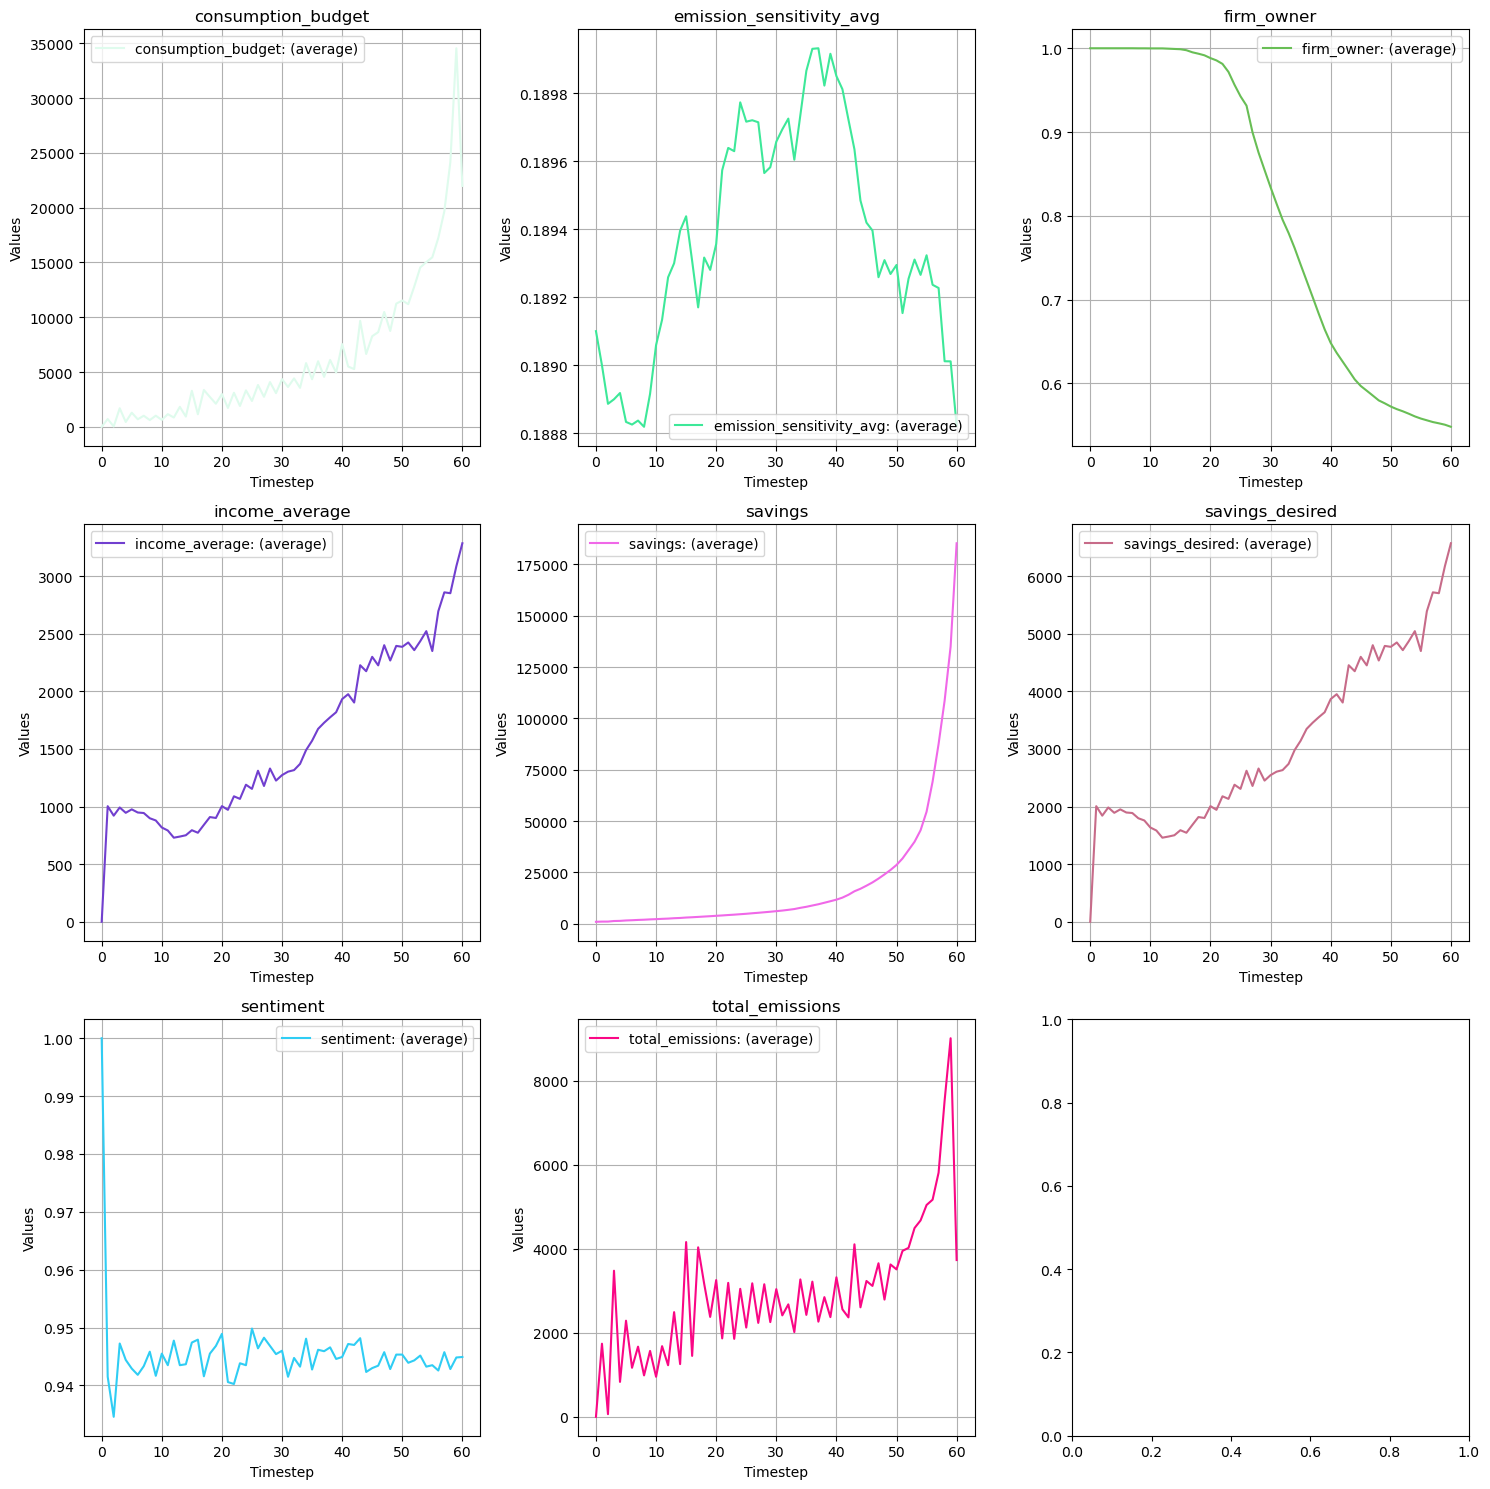

In [14]:
#cols_to_exclude = ['date']
#plot_values(households_sum,t,False, cols_to_exclude)
cols_to_exclude = ['date', "c_f", "c_excess_money", "consumption_propensity", 
                   "saving_propensity","saving_propensity_optimist", "saving_propensity_pessimist", 

                   
                    "reservation_wage",
                   "income_wage", "income_dividend",
                
                    "unemployed", "unemp_duration","income_current","income_unemployment_benefit",
                    "unemp_duration_upper_bound", "id"] 
plot_values(households_owners_avg,t,True, cols_to_exclude)

###  Plot firms

In [15]:
cols_to_exclude = ['date', "dividend_ratio", "dividend_ratio_optimistic", "dividend_ratio_pessimistic",
                   
                
                    
                    "inventory_reaction_factor", "desired_labor_capacity_utilization", 
                   
                   "id","is_cons_firm"
                   
                   , "bankrupt", "sentiment"
]

#### Plot Consumer Firms

------ Plotting consumer firms -----


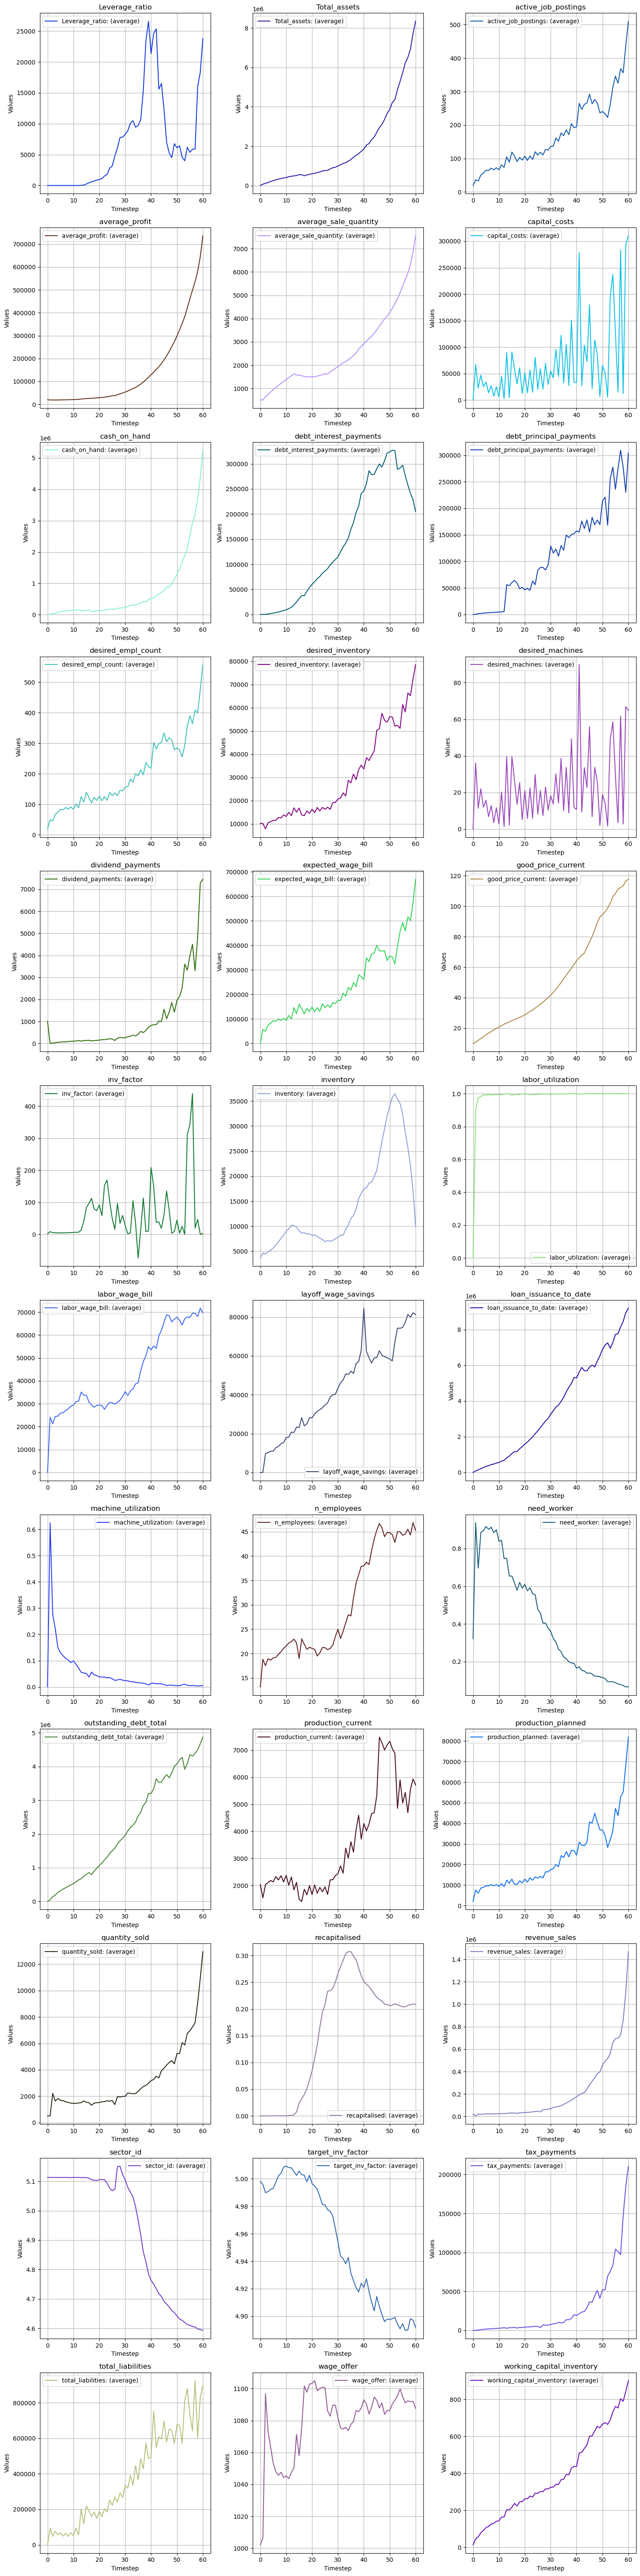

In [16]:
print("------ Plotting consumer firms -----")
#plot_values(cons_firms_sum,t,False, cols_to_exclude)

plot_values(cons_firms_avg,t,True, cols_to_exclude)

### Capital Firms

------ Plotting capital firms -----


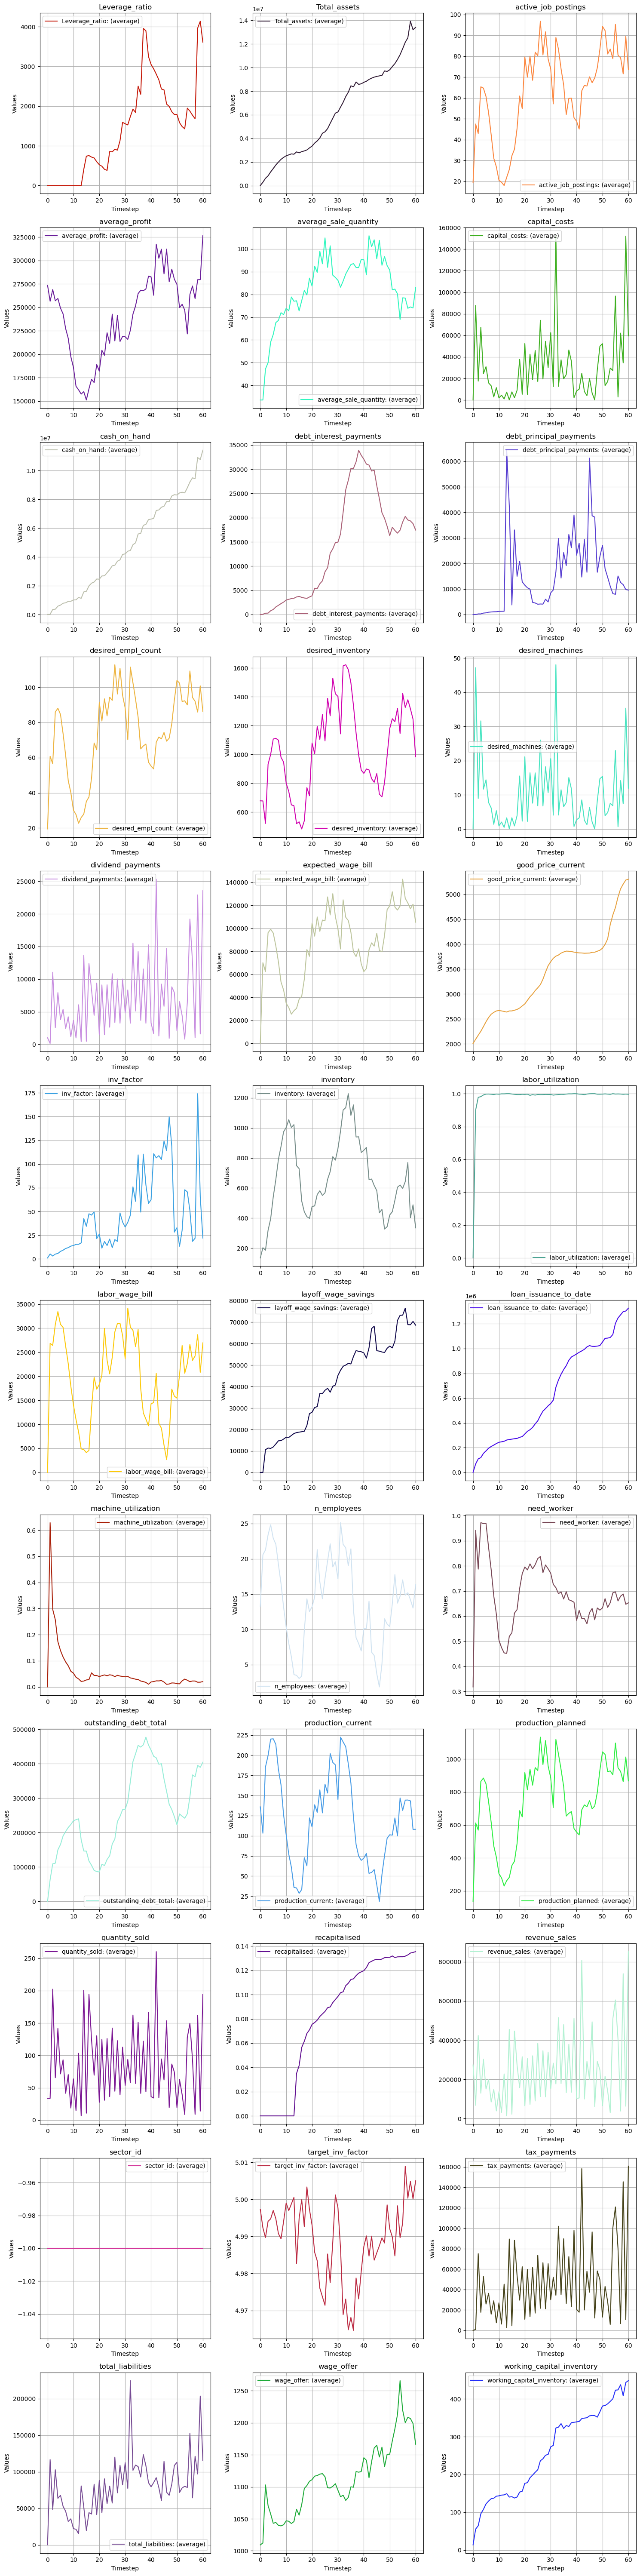

In [17]:
print("------ Plotting capital firms -----")

plot_values(cap_firms_avg,t,True, cols_to_exclude)

### Print Public Board

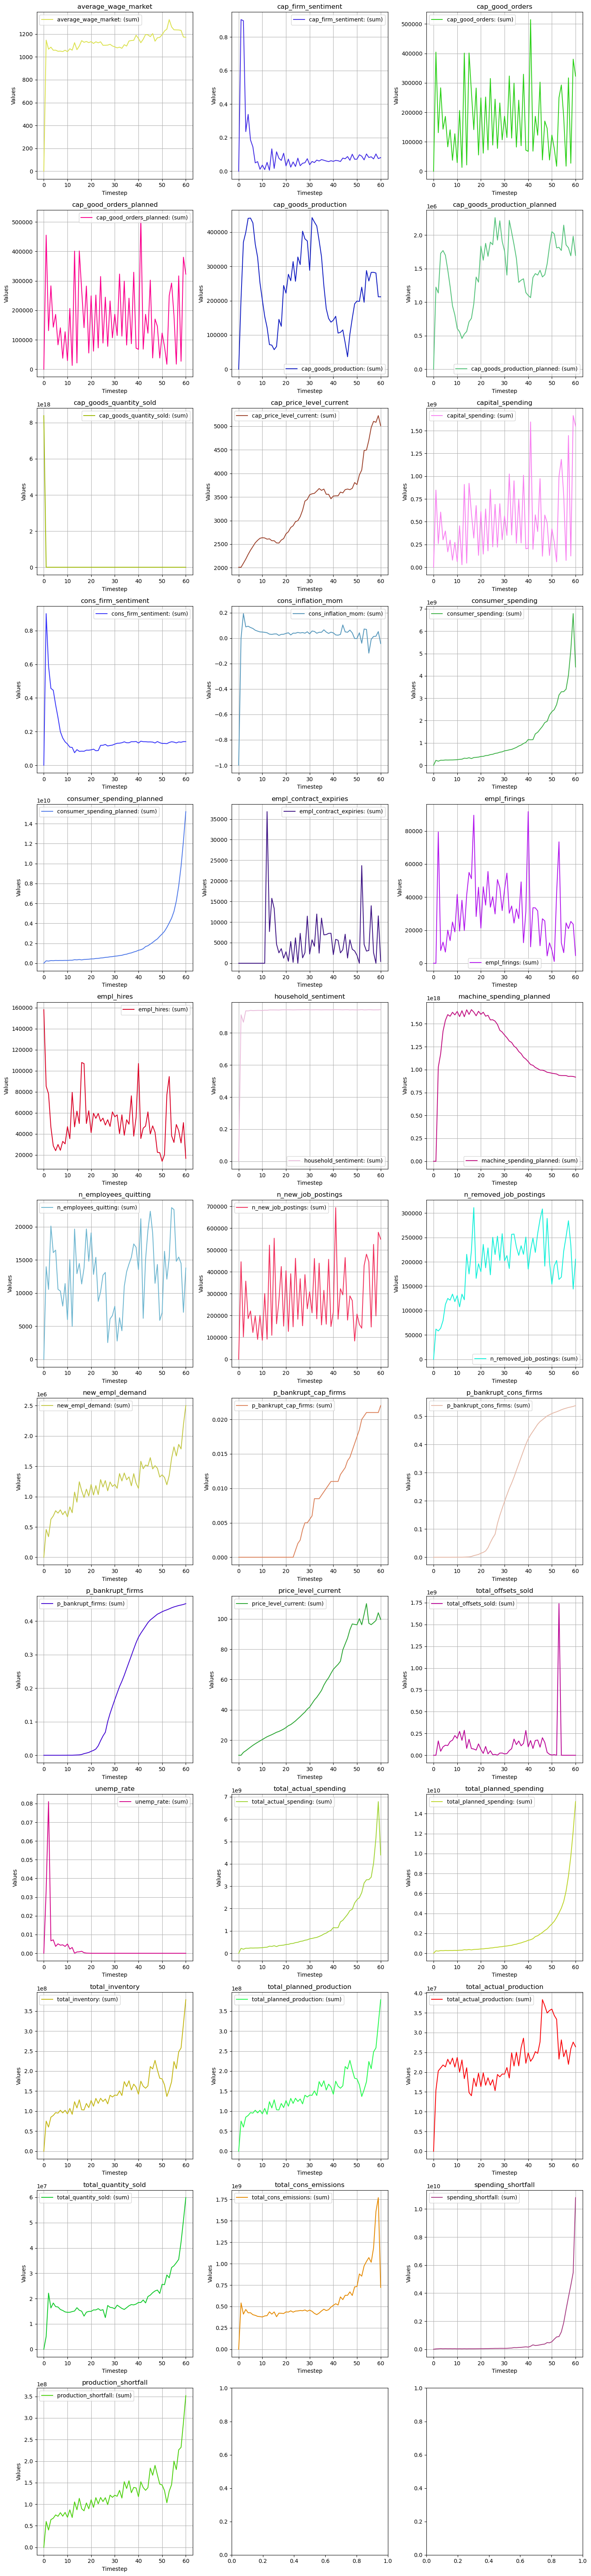

In [23]:
cols_to_exclude = [
   'date', "price_level_previous","cap_price_level_previous","n_employed", "n_unemployed", 
   "cap_firm_sentiment_sum", "cons_firm_sentiment_sum", "unempl_benefits", "household_sentiment_sum", "price_level_cons_sector_", 
   
   "household_unemployment_income", "consumption_budget", "average_wage_employed",

   "actual_spending_on_sector", "inventory_by_sector_", "offsets_sold_by_sector_", "planned_production_on_sector",
   "planned_spending_on_sector", "quantity_sold_by_sector", "total_cons_emissions_by_sector_","actual_production_on_sector",
   "minimum_wage", "emission_offset_price", "total_firm_emissions_by_sector", "total_emission_allowance",
   "id"
                ]
plot_values(pboard,t,False, cols_to_exclude)

# Bank

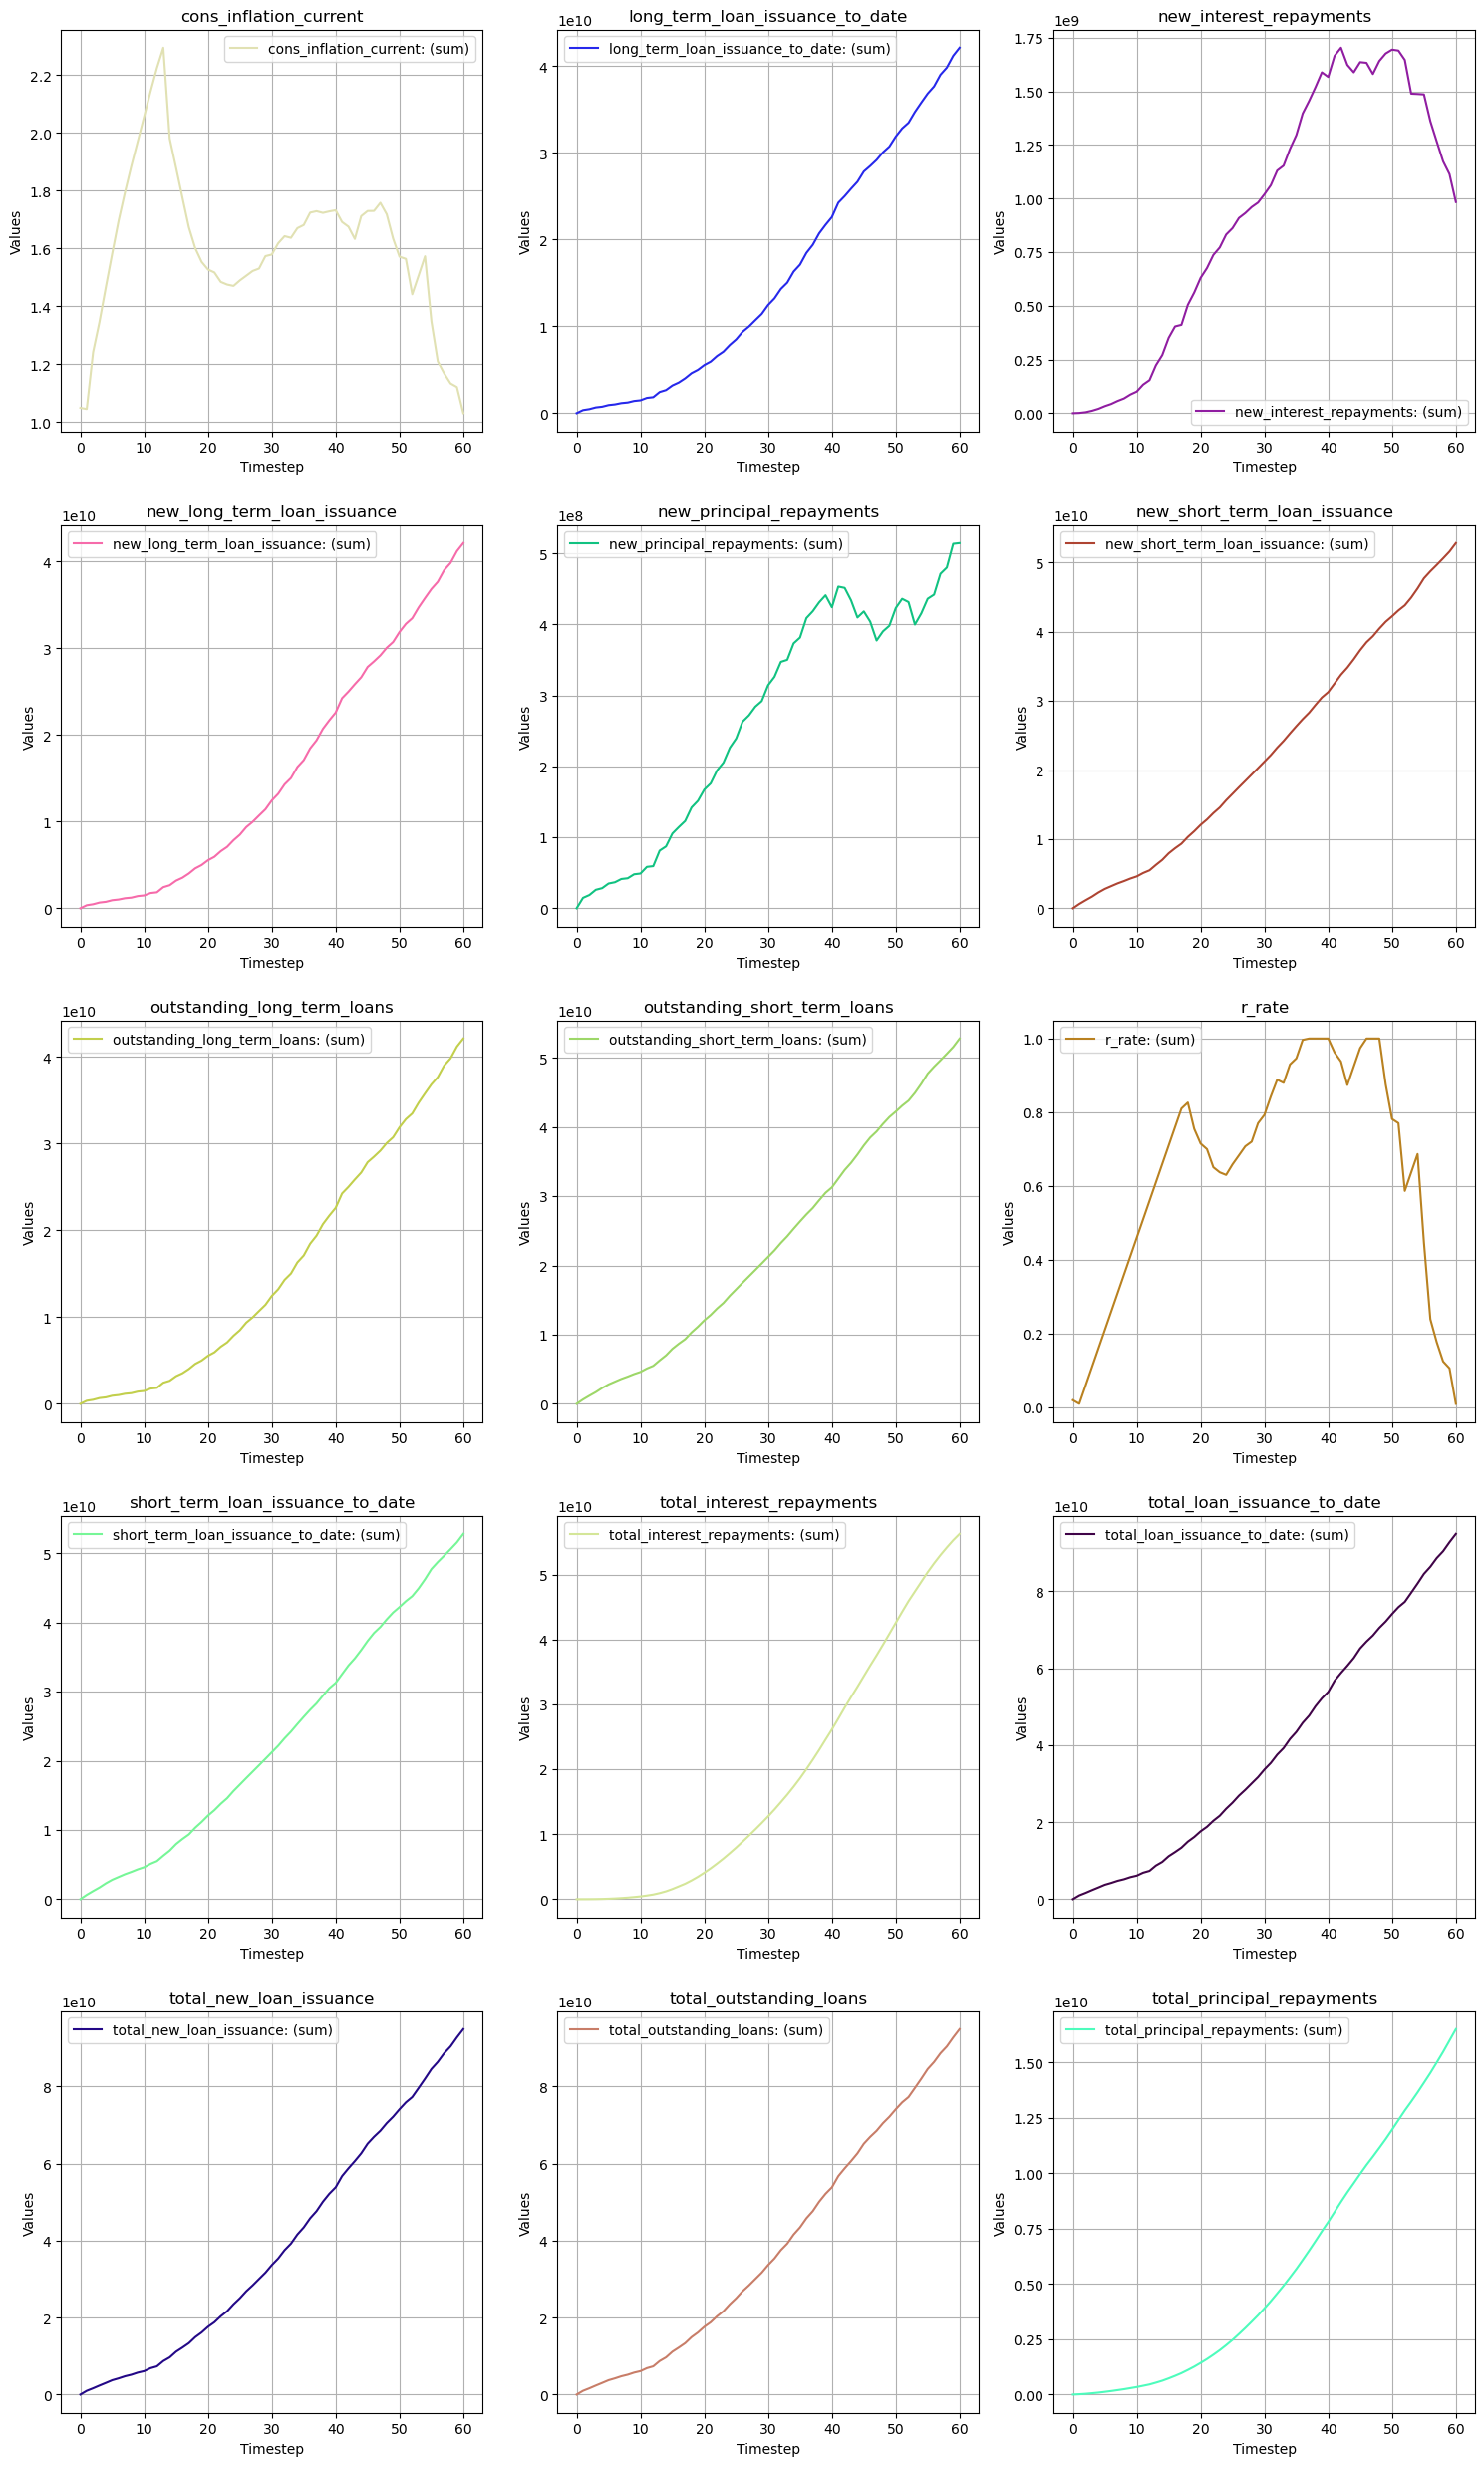

In [19]:
cols_to_exclude = ['date']
plot_values(bank,t,False, cols_to_exclude)

#### Interesting composite plots

pLOT beveridge curves and setc

Interest rate, inflation, employment, bankruptcies

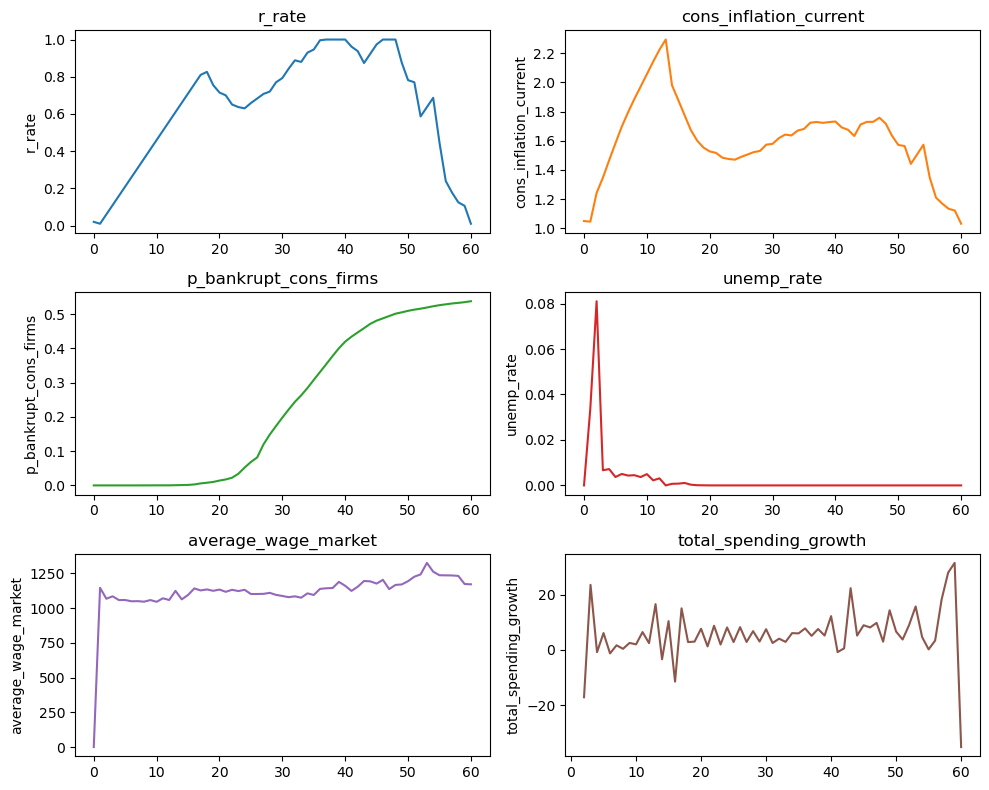

In [35]:
plot_columns(3, "summary_plot", bank, "r_rate", bank, "cons_inflation_current", pboard, "p_bankrupt_cons_firms", pboard, "unemp_rate",
pboard, "average_wage_market", pboard, "total_spending_growth" )

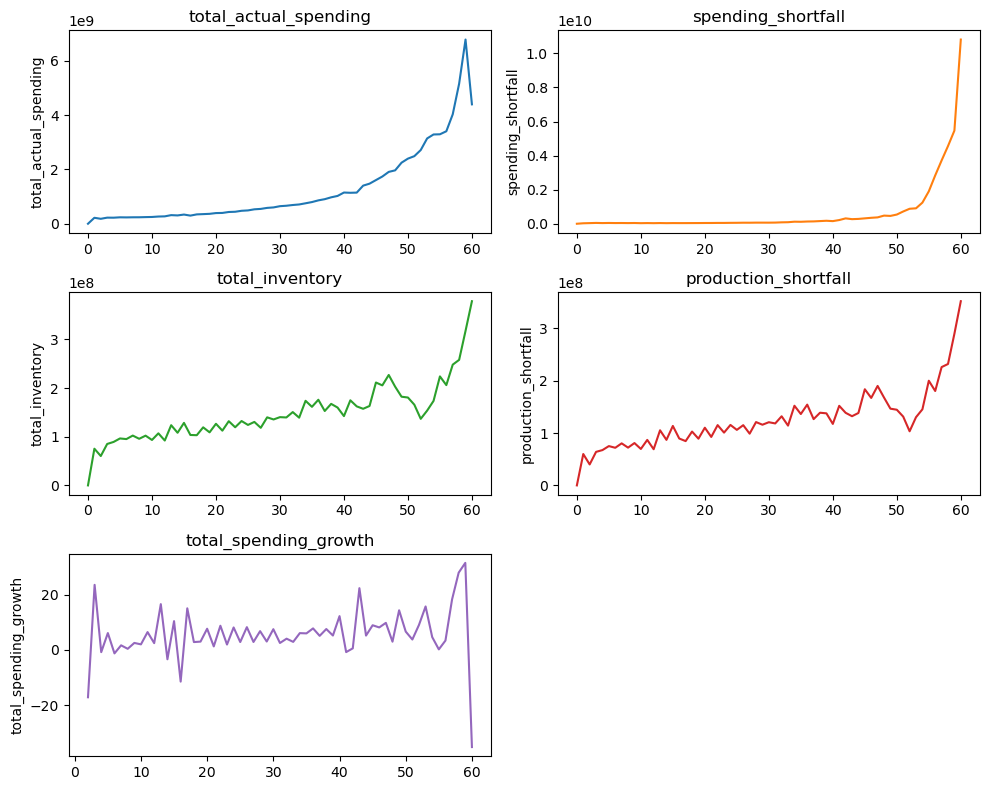

In [36]:
plot_columns(3, "spending_plot", pboard, "total_actual_spending", pboard, "spending_shortfall", pboard, "total_inventory", pboard, "production_shortfall",
pboard, "total_spending_growth")

In [ ]:
pboard[]

Plot histograms

Worker income distribution

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


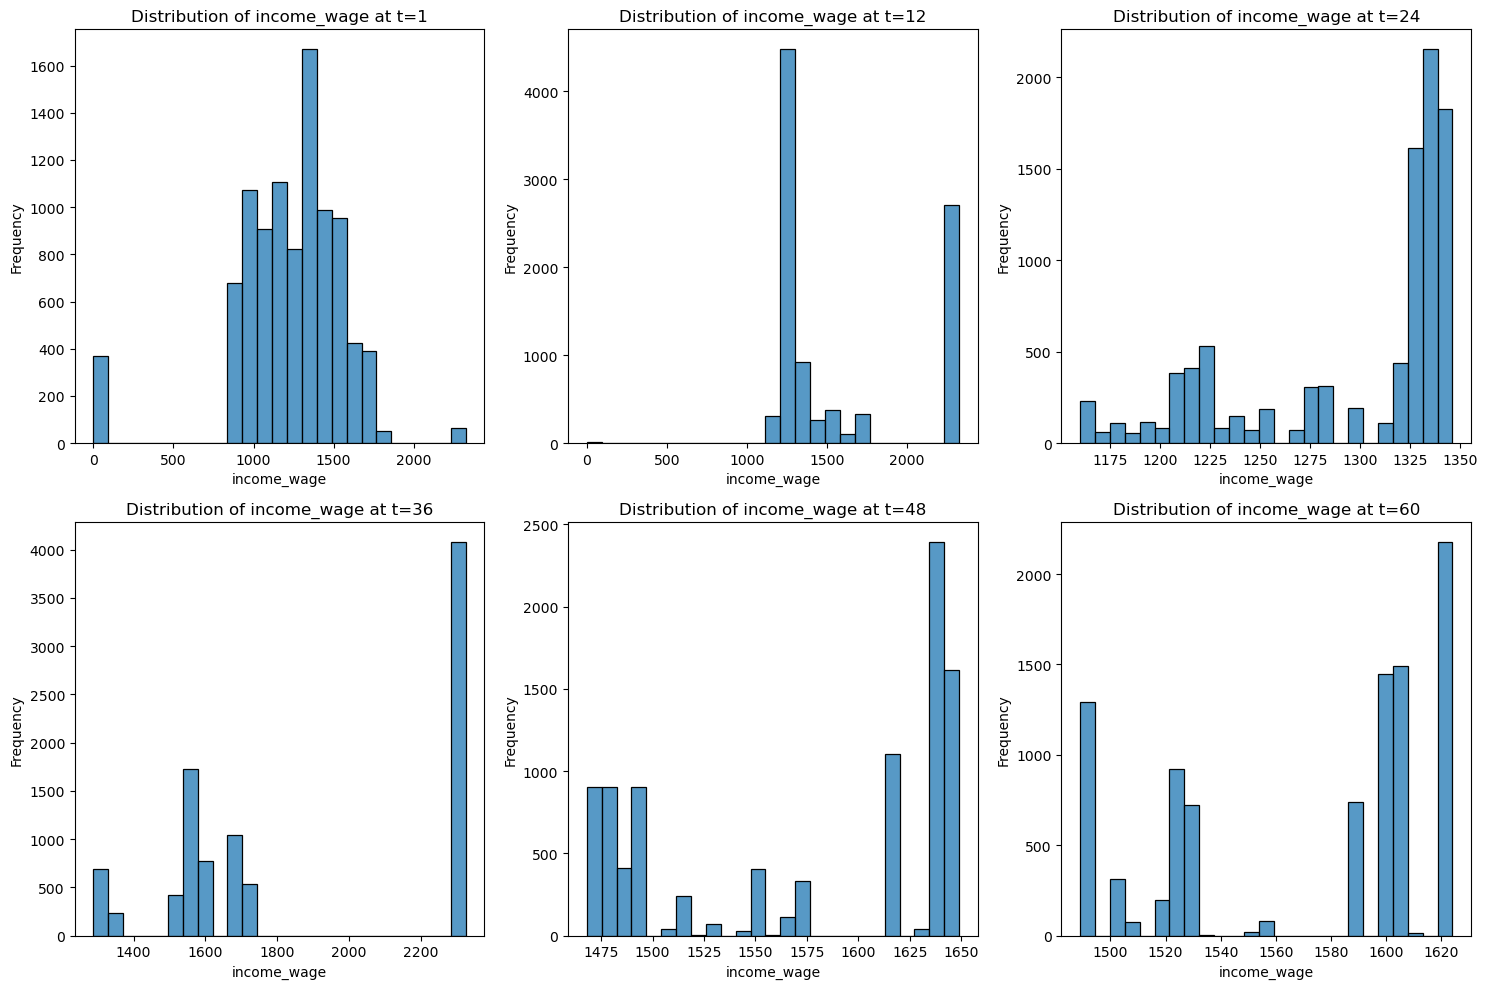

[{'date': 1,
  'mean': 1230.3190526315789,
  'std': 349.686796826045,
  'min': 0.0,
  'max': 2325.0,
  'uniform_distribution_bounds': (181.25866215344377, 2279.379443109714)},
 {'date': 12,
  'mean': 1592.9193684210527,
  'std': 478.54703530595145,
  'min': 0.0,
  'max': 2325.0,
  'uniform_distribution_bounds': (157.27826250319822, 2325.0)},
 {'date': 24,
  'mean': 1297.6624210526315,
  'std': 55.04593913004254,
  'min': 1160.0,
  'max': 1346.0,
  'uniform_distribution_bounds': (1160.0, 1346.0)},
 {'date': 36,
  'mean': 1884.948,
  'std': 393.24965601803365,
  'min': 1288.0,
  'max': 2325.0,
  'uniform_distribution_bounds': (1288.0, 2325.0)},
 {'date': 48,
  'mean': 1574.1841052631578,
  'std': 70.17441537713673,
  'min': 1468.0,
  'max': 1649.0,
  'uniform_distribution_bounds': (1468.0, 1649.0)},
 {'date': 60,
  'mean': 1571.6026315789475,
  'std': 49.18997393323439,
  'min': 1489.0,
  'max': 1624.0,
  'uniform_distribution_bounds': (1489.0, 1624.0)}]

In [ ]:
analyze_distribution(households_workers, 'income_wage', [1,12,24,36,48,60])

Firm sizes

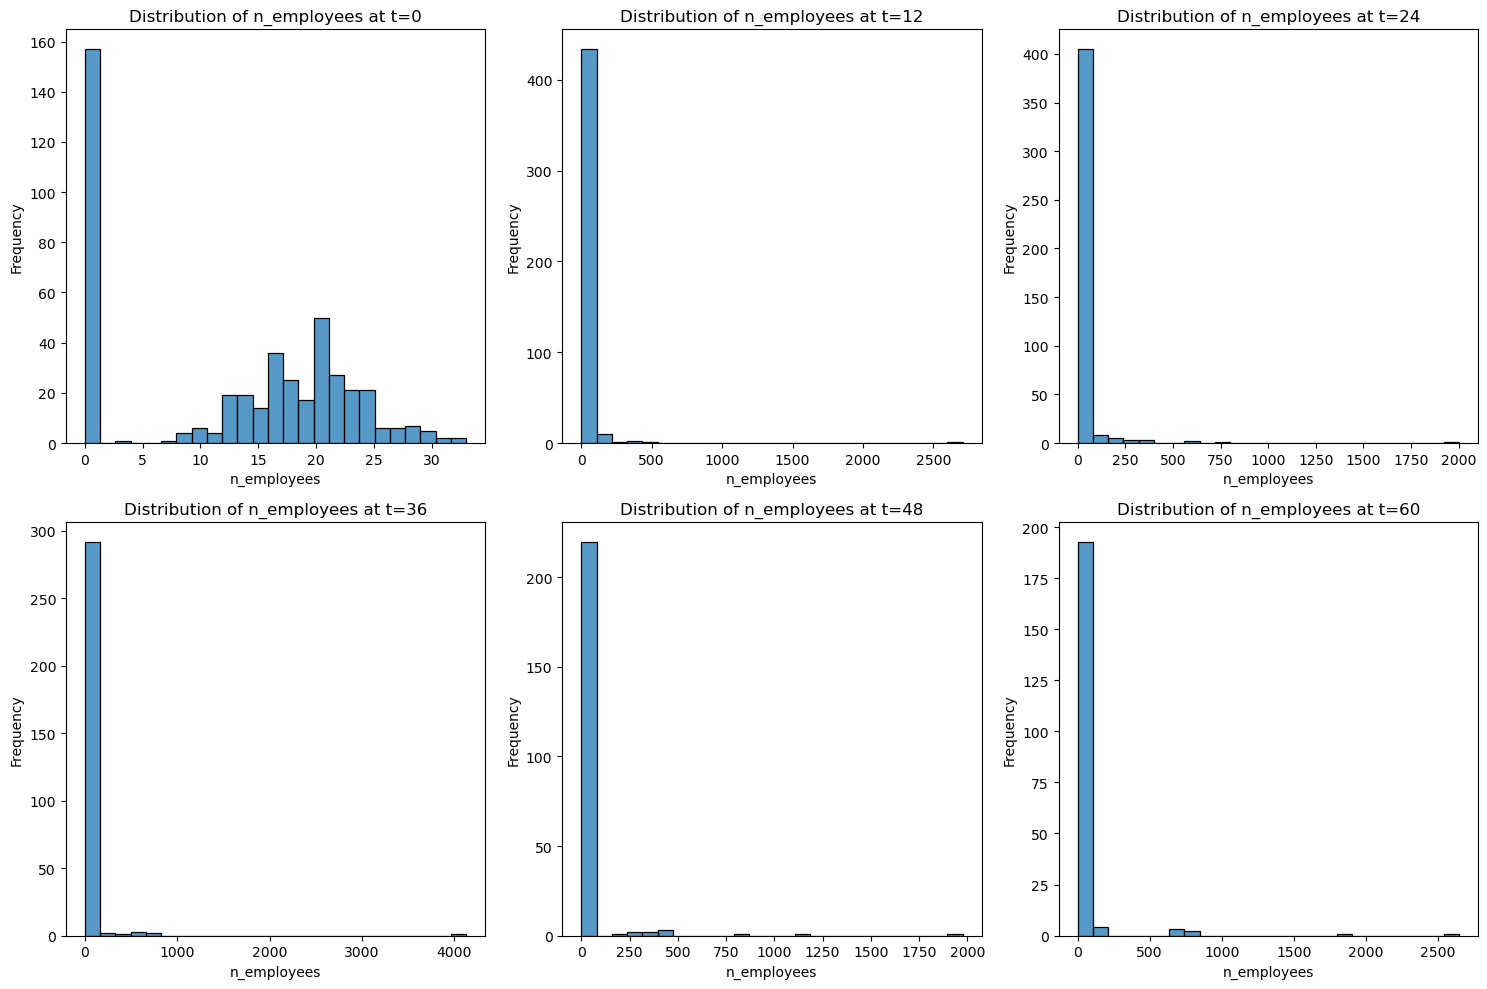

[{'date': 0,
  'mean': 12.528888888888888,
  'std': 10.002240778393764,
  'min': 0.0,
  'max': 33.0,
  'uniform_distribution_bounds': (0.0, 33.0)},
 {'date': 12,
  'mean': 19.879732739420934,
  'std': 134.79082261282767,
  'min': 0.0,
  'max': 2707.0,
  'uniform_distribution_bounds': (0.0, 424.2522005779039)},
 {'date': 24,
  'mean': 20.30140186915888,
  'std': 118.46510686146316,
  'min': 0.0,
  'max': 2001.0,
  'uniform_distribution_bounds': (0.0, 375.6967224535484)},
 {'date': 36,
  'mean': 30.19269102990033,
  'std': 251.96203962713685,
  'min': 0.0,
  'max': 4129.0,
  'uniform_distribution_bounds': (0.0, 786.0788099113108)},
 {'date': 48,
  'mean': 29.471861471861473,
  'std': 169.19257830238004,
  'min': 0.0,
  'max': 1975.0,
  'uniform_distribution_bounds': (0.0, 537.0495963790015)},
 {'date': 60,
  'mean': 43.89705882352941,
  'std': 251.25937806418,
  'min': 0.0,
  'max': 2645.0,
  'uniform_distribution_bounds': (0.0, 797.6751930160693)}]

In [ ]:
analyze_distribution(cons_firms, 'n_employees', [0,12,24,36,48,60])

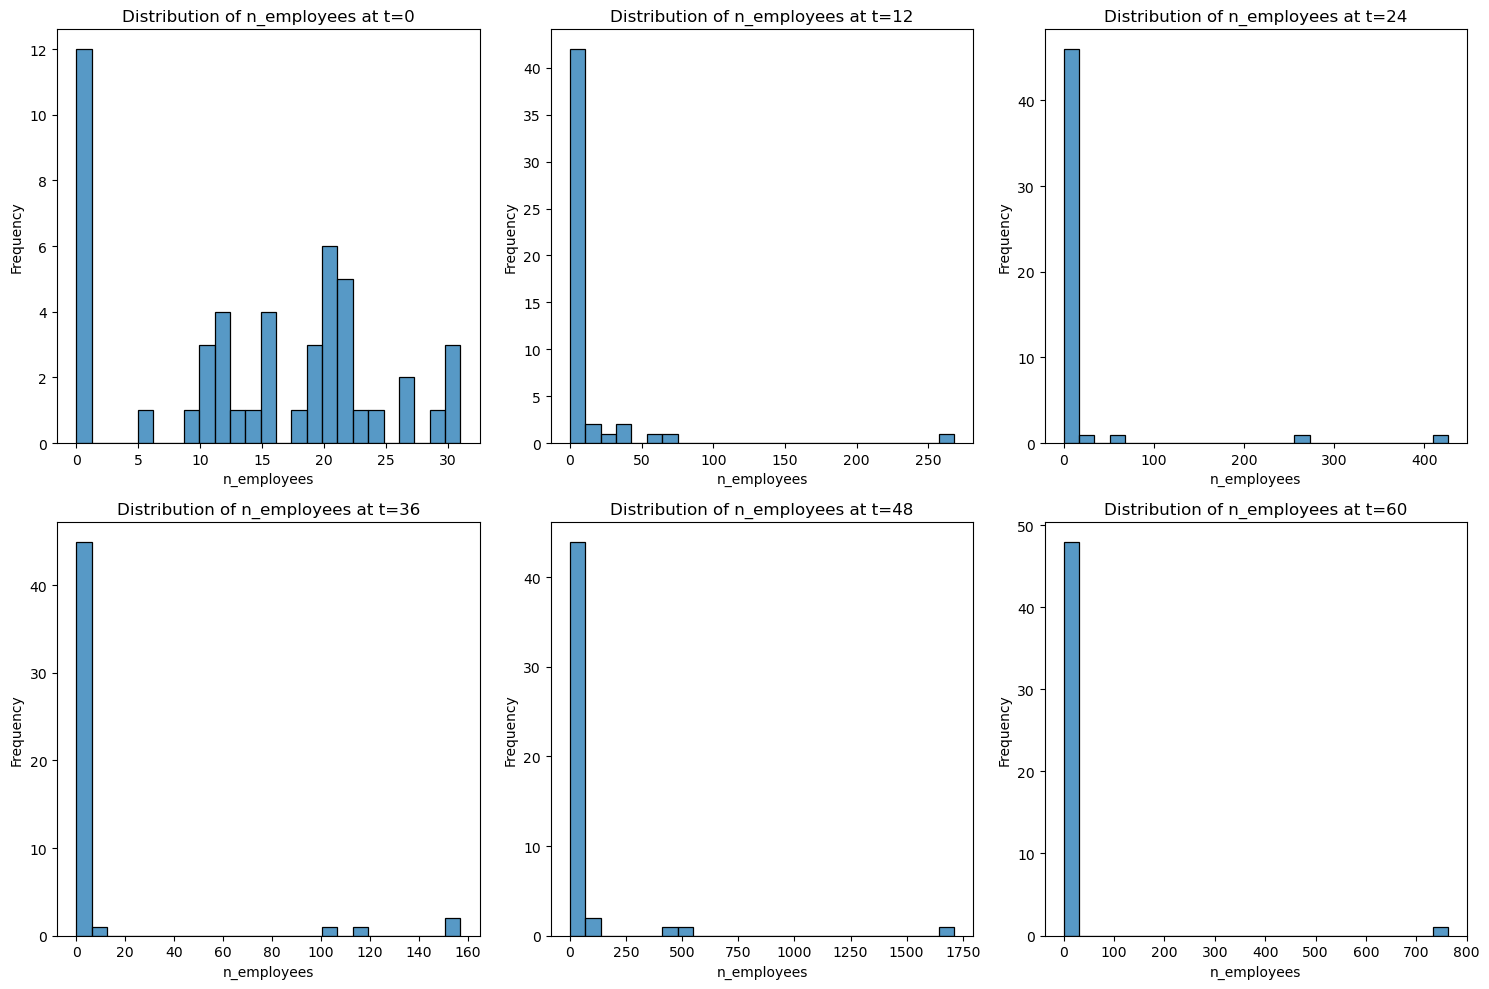

[{'date': 0,
  'mean': 14.24,
  'std': 9.832391284288219,
  'min': 0.0,
  'max': 31.0,
  'uniform_distribution_bounds': (0.0, 31.0)},
 {'date': 12,
  'mean': 11.16,
  'std': 40.00732585975946,
  'min': 0.0,
  'max': 268.0,
  'uniform_distribution_bounds': (0.0, 131.1819775792784)},
 {'date': 24,
  'mean': 15.76,
  'std': 70.31084335916866,
  'min': 0.0,
  'max': 426.0,
  'uniform_distribution_bounds': (0.0, 226.69253007750598)},
 {'date': 36,
  'mean': 11.22,
  'std': 36.97726273243699,
  'min': 0.0,
  'max': 157.0,
  'uniform_distribution_bounds': (0.0, 122.15178819731096)},
 {'date': 48,
  'mean': 59.42857142857143,
  'std': 259.770170856214,
  'min': 0.0,
  'max': 1712.0,
  'uniform_distribution_bounds': (0.0, 838.7390839972135)},
 {'date': 60,
  'mean': 16.163265306122447,
  'std': 108.99242078748249,
  'min': 0.0,
  'max': 763.0,
  'uniform_distribution_bounds': (0.0, 343.1405276685699)}]

In [ ]:
analyze_distribution(cap_firms, 'n_employees', [0,12,24,36,48,60])